In [178]:
using RxInfer, BenchmarkTools, Random, LinearAlgebra, Plots, GraphViz, Optim

In [179]:
function generate_data(rng, A, B, P, Q)
    x_prev = [ 10.0, -10.0 ]

    x = Vector{Vector{Float64}}(undef, n)
    y = Vector{Vector{Float64}}(undef, n)

    for i in 1:n
        x[i] = rand(rng, MvNormalMeanCovariance(A * x_prev, P))
        y[i] = rand(rng, MvNormalMeanCovariance(B * x[i], Q))
        x_prev = x[i]
    end
    
    return x, y
end

generate_data (generic function with 1 method)

In [180]:
# Seed for reproducibility
seed = 1234

rng = MersenneTwister(1234)

# We will model 2-dimensional observations with rotation matrix `A`
# To avoid clutter we also assume that matrices `A`, `B`, `P` and `Q`
# are known and fixed for all time-steps
θ = π / 35
A_real = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
B = diageye(2)
Q = 25.0 * diageye(2)
P = diageye(2)

# Number of observations
n = 200;

In [181]:
x, y = generate_data(rng, A_real, B, P, Q);

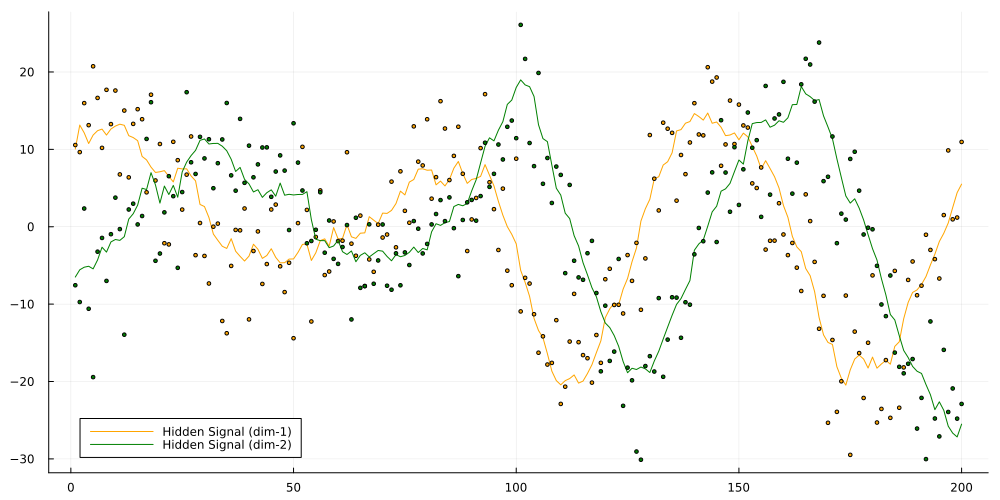

In [182]:
px = plot()

px = plot!(px, getindex.(x, 1), label = "Hidden Signal (dim-1)", color = :orange)
px = scatter!(px, getindex.(y, 1), label = false, markersize = 2, color = :orange)
px = plot!(px, getindex.(x, 2), label = "Hidden Signal (dim-2)", color = :green)
px = scatter!(px, getindex.(y, 2), label = false, markersize = 2, color = :green)

plot(px, size = (1000, 500))

In [183]:
@model function rotate_ssm(y, x0, A, B, P, Q)
    x_prior ~ x0
    x_prev = x_prior
    
    for i in 1:length(y)
        x[i] ~ MvNormalMeanCovariance(A * x_prev, P)
        y[i] ~ MvNormalMeanCovariance(B * x[i], Q)
        x_prev = x[i]
    end

end

In [184]:
x0 = MvNormalMeanCovariance(zeros(2), 100.0 * diageye(2));

In [185]:
function f(params)
    A = [params[1] params[2]; params[3] params[4]]
    result = infer(
        model = rotate_ssm(x0=x0, A=A, B=B, P=P, Q=Q), 
        data = (y = y,),
        free_energy = true
    )
    return result.free_energy[end]
end

f (generic function with 1 method)

In [186]:
res = optimize(f, zeros(4), GradientDescent(), Optim.Options(g_tol = 1e-3, iterations = 100, store_trace = true, show_trace = true, show_every = 10))

Iter     Function value   Gradient norm 
     0     2.000162e+03     3.126943e+01
 * time: 0.031000137329101562
    10     1.264645e+03     2.627805e-02
 * time: 24.337000131607056


 * Status: success

 * Candidate solution
    Final objective value:     1.264645e+03

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 9.23e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.23e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.66e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.06e-14 ≰ 0.0e+00
    |g(x)|                 = 2.79e-04 ≤ 1.0e-03

 * Work counters
    Seconds run:   28  (vs limit Inf)
    Iterations:    13
    f(x) calls:    51
    ∇f(x) calls:   51


In [189]:
println("Real value vs Optimized")
println("Real:      ", A_real)
println("Optimized: ", res.minimizer, " Det: ", det([res.minimizer[1] res.minimizer[2]; res.minimizer[3] res.minimizer[4]]))

Real value vs Optimized
Real:      [0.9959742939952391 -0.0896393089034335; 0.0896393089034335 0.9959742939952391]
Optimized: [0.989497912127122, -0.08934819289265862, 0.09520710388415556, 0.99989132718673] Det: 0.9978969632878794
